# PCA y K-means - Handwritten Digit - MNIST

En éste ejercicio vamos a aplicar PCA y K-means al dataset de Handwritten digit MNIST, que incluye imágenes de números escritos a mano del 0 al 9 de 28x28. La idea es intentar recopilar información sobre la distribución de las imágenes, usando visualizaciones que permitan clarificar cómo interpretar los resultados obtenidos por PCA.

### Importamos librerías

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import os
import gzip
import sys
import pandas as pd
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

In [81]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure

### Importamos el dataset

In [3]:
# Descarga del dataset:
import keras
from keras.datasets import mnist

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train.shape

(60000, 28, 28)

* 60 mil imágenes de 20 x 20 pixels

In [6]:
x_train = x_train.reshape((60000, 28 * 28 * 1))

In [7]:
x_train.shape

(60000, 784)

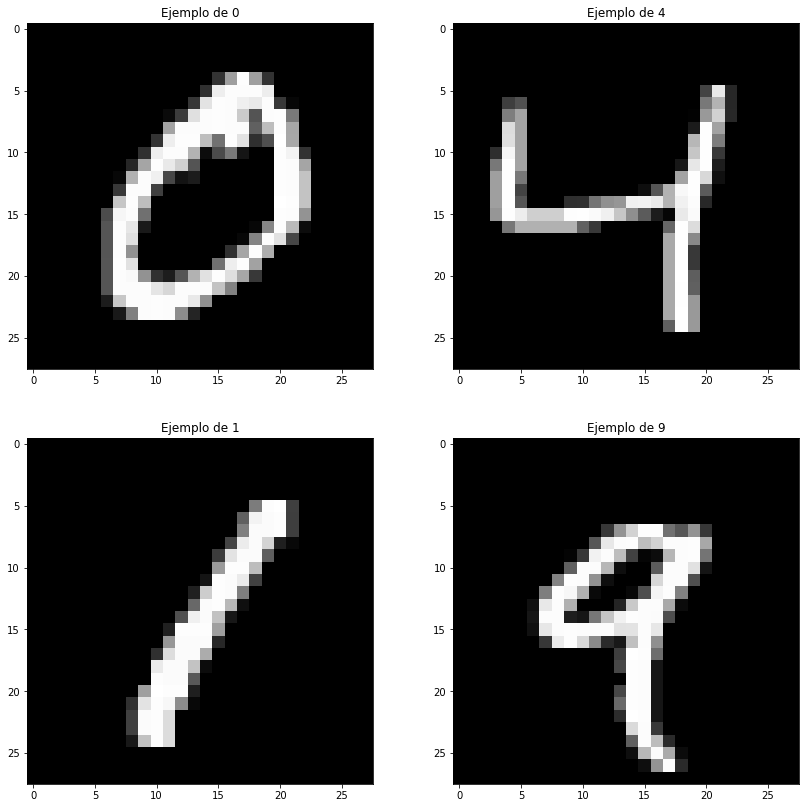

In [8]:
# Cargamos una muestra de digitos
fig=plt.figure(figsize=(14, 14))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.title("Ejemplo de {}".format(y_train[i]))
    plt.imshow(x_train[i, :].reshape((28, 28)), cmap='gray')
plt.show()

### Creamos una Clase PCA

In [376]:
class PCA_GMNIST_2:
    def __init__(self, X, y, n_components, whiten = False):
        '''
        inputs: 
            X                    - dataset de entrada
            y                    - labels
            n_components         - cantidad de componentes principales a usar
            whiten               - indica si se multiplica los elementos por
                                   la raiz cuadrada de X.shape[0] y se divide por los valores singulares --> varianza unitaria
        '''
        
        self.n_components = n_components
        self.with_whiten = whiten
        self.y = y
        self.X = X
        self.y_mapping = ['0','1','2','3','4','5','6','7','8','9']
        
        # Normalizamos el dataset
        self.scaler = StandardScaler()
        # Ver diferencias entre StandardScaler y Normalize
        self.X_norm = self.scaler.fit_transform(X)
        #self.X_norm = normalize(X)
        
        # Aplicamos PCA al dataset normalizado
        self.PCAModel = PCA(n_components=self.n_components, whiten=self.with_whiten)
        self.X_norm_r = self.PCAModel.fit_transform(self.X_norm)
        
    @staticmethod
    def plot_image(x):
        plt.imshow(x.reshape((28, 28)), cmap='gray')
    
    @staticmethod
    def MSE(X, vector):
        n = X.shape[1]
        return np.sum((X - vector) ** 2, axis=1) / n
        
    def get_model(self):
        return self.PCAModel
    
    def PCA_transform(self):
        return self.PCAModel.transform(self.X)
    
    def get_norm(self):
        return self.X_norm_r

    def PCA_reconstruct(self, X_transformed):
        return self.PCAModel.inverse_transform(X_transformed) 
    
    def InterpretUsingModel(self, X):
        return self.PCAModel.inverse_transform(self.PCAModel.transform(X))
        
    def variance_plot_acumulada(self, n_components):
       
        x = range(n_components)
        y = np.cumsum(self.PCAModel.explained_variance_ratio_[:n_components])
        g = np.full((n_components), 0.9)
        idx = np.argwhere(np.diff(np.sign(y - g))).flatten()
        
        fig, axs = plt.subplots(1,1)
        fig.set_size_inches(12, 5, forward=True)
        plt.plot(x[idx[0]], y[idx[0]], 'ro')
        axs.axvline(x=x[idx[0]],color='r')
        axs.annotate(x[idx[0]], xy =(x[idx[0]],y[idx[0]]),xytext =(x[idx[0]],y[idx[0]]))
        plt.plot(x, y, '-')
        plt.plot(x, g, '-')
        
    def variance_plot(self, n_components):
        fig, axs = plt.subplots(1,1)
        fig.set_size_inches(12, 5, forward=True)
        plt.plot(range(n_components), self.PCAModel.explained_variance_ratio_[:n_components])
        plt.title("Varianza explicada por componente", fontsize=10)
        
    def plot_reconstructions(self, X, numReconstructions=5):
        numSamples = np.shape(X)[0]
        numReconstructions = min(numReconstructions, numSamples)
        numReconstructionsPerFigure = min(5, numReconstructions)
        numFigures = int(np.ceil(float(numReconstructions)/numReconstructionsPerFigure))
                
        for figureidx in range(numFigures):
            plt.figure(figsize = (18, 18))
            for plotCol in range(numReconstructionsPerFigure):
                data_idx = np.random.randint(numSamples)
                originalImage = X[data_idx,:].ravel()
                reconstructedImage = self.InterpretUsingModel(np.reshape(X[data_idx,:],[1,-1])).ravel()
                diffImage = abs(originalImage - reconstructedImage)
                
                # original image
                plt.subplot(3,numReconstructionsPerFigure,0*numReconstructionsPerFigure+plotCol+1)
                self.plot_image(originalImage)
                plt.title('Imagen original') 
                plt.axis('off')
                    
                # reconstred image
                plt.subplot(3,numReconstructionsPerFigure,1*numReconstructionsPerFigure+plotCol+1)
                self.plot_image(reconstructedImage) 
                plt.title('Imagen reconstruida') 
                plt.axis('off')

                # diff image
                plt.subplot(3,numReconstructionsPerFigure,2*numReconstructionsPerFigure+plotCol+1)
                self.plot_image(diffImage) 
                plt.title('Diferencia absoluta')
                plt.axis('off')
            plt.tight_layout()
    
    def quantile_records(self, X, vector, q=0.5):
        """
        Devuelve el cuantil q del ECM entre la salida original y transformada para un determinado componente.
        """
        errors = self.MSE(X, vector)
        q_value = np.quantile(errors, q, interpolation="lower")
        record = errors==q_value
        return X[record, :]   
    
    def plot_quartiles(self, X, trans, n):
        fig, axarr = plt.subplots(n, 7, figsize=(12, n*2))
        for i in range(n):
            vector = trans.components_[i, :]
            sns.heatmap(self.quantile_records(X, vector, q=0.02).reshape(28, 28), cmap='gray_r', ax=axarr[i][0], cbar=False)
            axarr[i][0].set_aspect('equal')
            axarr[i][0].axis('off')

            sns.heatmap(self.quantile_records(X, vector, q=0.1).reshape(28, 28), cmap='gray_r', ax=axarr[i][1], cbar=False)
            axarr[i][1].set_aspect('equal')
            axarr[i][1].axis('off')

            sns.heatmap(self.quantile_records(X, vector, q=0.25).reshape(28, 28), cmap='gray_r', ax=axarr[i][2], cbar=False)
            axarr[i][2].set_aspect('equal')
            axarr[i][2].axis('off')

            sns.heatmap(self.quantile_records(X, vector, q=0.5).reshape(28, 28), cmap='gray_r', ax=axarr[i][3], cbar=False)
            axarr[i][3].set_aspect('equal')
            axarr[i][3].axis('off')

            sns.heatmap(self.quantile_records(X, vector, q=0.75).reshape(28, 28), cmap='gray_r', ax=axarr[i][4], cbar=False)
            axarr[i][4].set_aspect('equal')
            axarr[i][4].axis('off')

            sns.heatmap(self.quantile_records(X, vector, q=0.9).reshape(28, 28), cmap='gray_r', ax=axarr[i][5], cbar=False)
            axarr[i][5].set_aspect('equal')
            axarr[i][5].axis('off')        

            sns.heatmap(self.quantile_records(X, vector, q=0.98).reshape(28, 28), cmap='gray_r', ax=axarr[i][6], cbar=False)        
            axarr[i][6].set_aspect('equal')
            axarr[i][6].axis('off')

        axarr[0][0].set_title('2nd Percentile', fontsize=12)
        axarr[0][1].set_title('10th Percentile', fontsize=12)
        axarr[0][2].set_title('25th Percentile', fontsize=12)
        axarr[0][3].set_title('50th Percentile', fontsize=12)
        axarr[0][4].set_title('75th Percentile', fontsize=12)
        axarr[0][5].set_title('90th Percentile', fontsize=12)
        axarr[0][6].set_title('98th Percentile', fontsize=12)
        
    def plot_pca_space_2d(self):
        plt.figure(figsize=(12,10))
        plt.scatter(self.X_norm_r[:, 0], self.X_norm_r[:, 1], c=self.y, 
        edgecolor='none', alpha=0.7, s=40,
        cmap=plt.cm.get_cmap('nipy_spectral', 10))
        plt.colorbar()
        plt.title('FMNIST - PCA projection 2D');

### 1 -  Aplicar PCA sobre el dataset para poder explicar el 90% de la varianza. ¿Cuántos componentes se requieren?

In [377]:
# Instanciamos la clase
PCA_FM = PCA_GMNIST_2(x_train, y_train, 0.9)

In [252]:
X_pca = PCA_FM.PCA_transform()
X_pca.shape[1]

236

In [253]:
PCA_FM = PCA_GMNIST_2(x_train, y_train, 350)

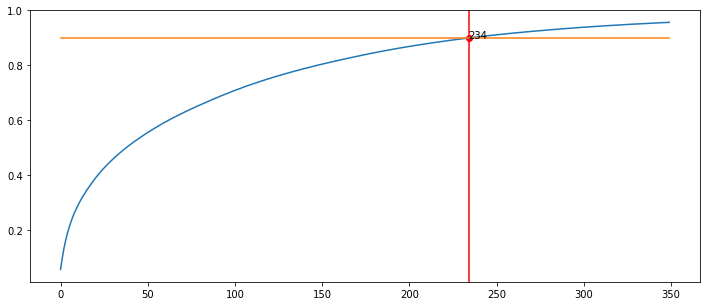

In [254]:
# Ploteamos el ratio de explicabilidad de la varianza en función de la cantidad de componentes principales
PCA_FM.variance_plot_acumulada(n_components=350)

* Con 234 componenetes se explica el 90% de la varianza.

### 2. Graﬁcar un scree plot (varianza contemplada en función del número de componentes considerados)


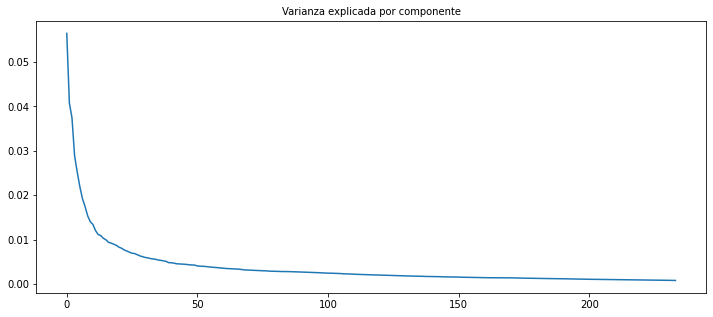

In [255]:
PCA_FM.variance_plot(n_components=234)

### 3 - Visualizar gráﬁcamente los primeros 5 componentes ¿Qué conclusiones se puede sacar de cada componente?

In [256]:
# Instanciamos la clase con solo 5 componenetes:
PCA_FM = PCA_GMNIST_2(x_train, y_train, 5)

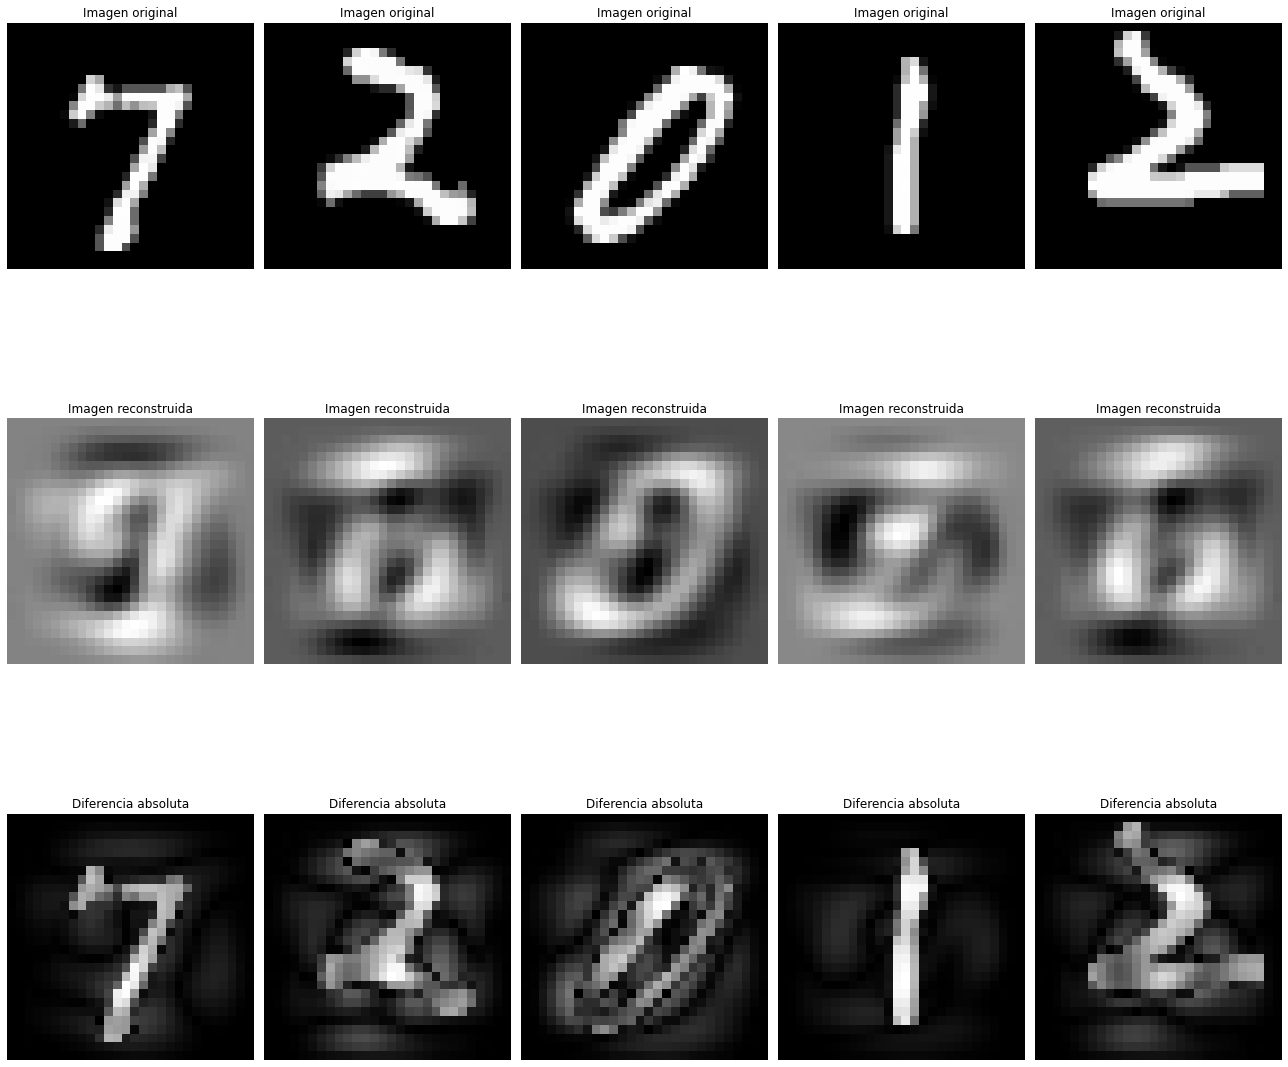

In [257]:
# Mostramos algunas reconstrucciones
PCA_FM.plot_reconstructions(x_train, 5)

* Se observa que no se logra reconstruir muy bien la imagen con solo los primeros 5 componentes, se puede ver que la diferencia entre la imagen original y la imagen reconstruida es muy grande. 

### 4 - Visualizar la imagen original vs. la reconstruida con los 234 componentes.

In [258]:
# Instanciamos la clase con solo 234 componenetes:
PCA_FM = PCA_GMNIST_2(x_train, y_train, 234)

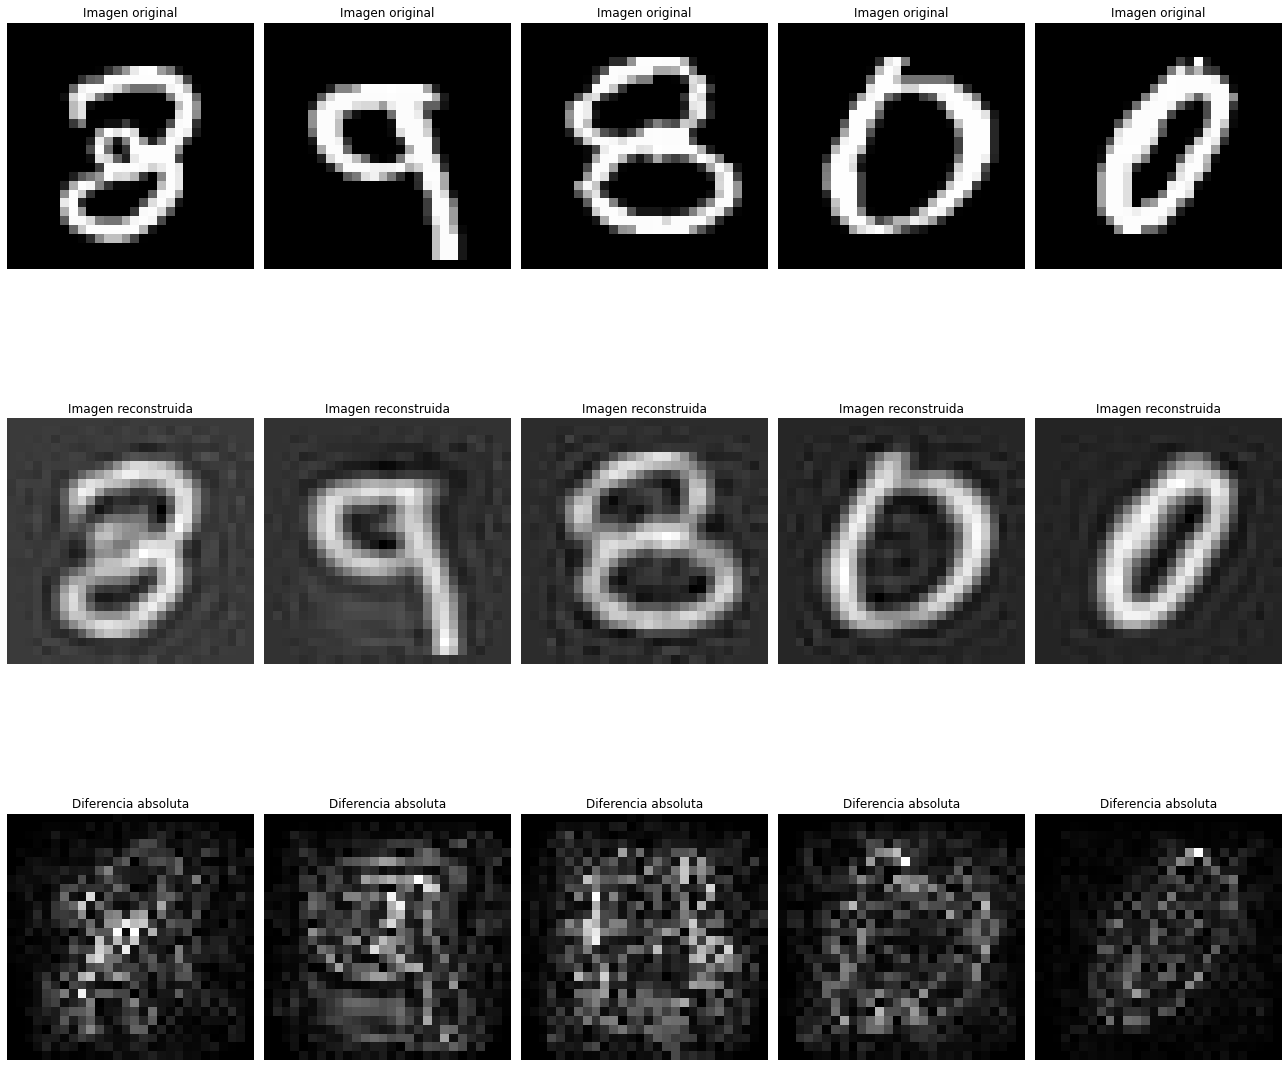

In [259]:
# Mostramos algunas reconstrucciones
PCA_FM.plot_reconstructions(x_train, 5)

* Utilizando 234 componentes se logra reconstruir mucho mejor la imagen, con un error de reconstrucción bastante bajo.

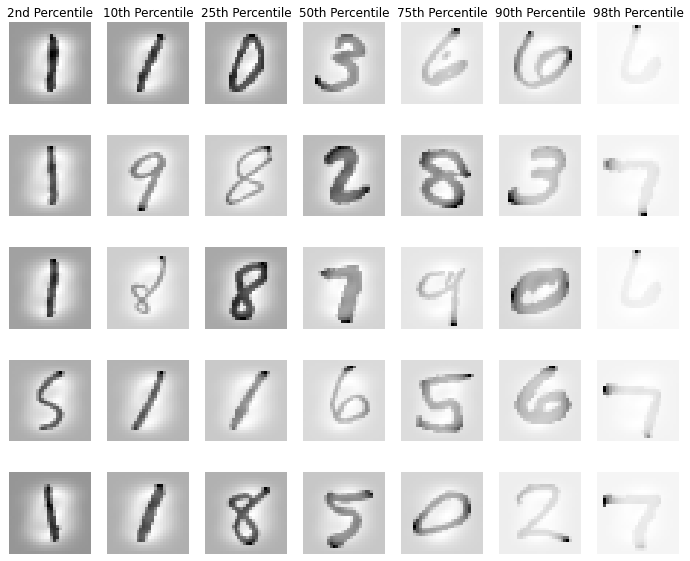

In [260]:
# Plotear cuartiles de 5 componentes
PCA_FM.plot_quartiles(PCA_FM.X_norm, PCA_FM.PCAModel, 5)

* Se observa que el primer componente aporto mucha información sobre los patrones en los números.

### 5 - Graﬁcar una matriz de correlación del dataset reducido.

In [420]:
# Instanciamos la clase con solo 20 componenetes:
PCA_FM = PCA_GMNIST_2(x_train[0:51], y_train[0:51], 50)

In [421]:
pca =  PCA_FM.get_norm()

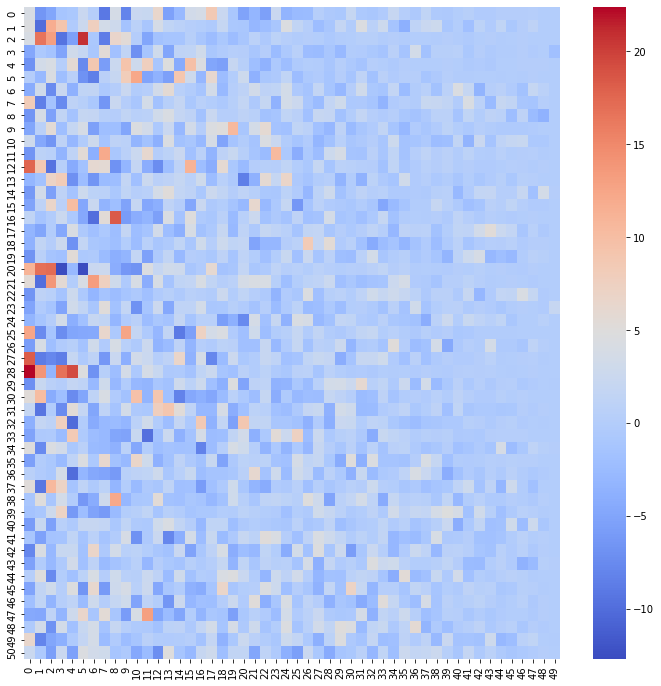

In [422]:
figure(figsize=(12,12))
ax = sns.heatmap(pca, cmap='coolwarm')

* Se observa que los primeros componentes muestran mayor correlación con las imagenes.